In [ ]:
base_path = '/content/data/'
class_names = ['glioma', 'meningioma', 'notumor', 'pituitary']

IMAGE_SIZE = 128
BATCH_SIZE = 16
VERBOSE = 1

In [ ]:
import zipfile
import os

zip_file_path = '/content/drive/My Drive/majordata.zip'

extract_dir = '/content/data/'

os.makedirs(extract_dir, exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print("Extraction complete!")


Extraction complete!


In [ ]:
import cv2
import os
import sklearn
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import Xception
from tensorflow.keras.callbacks import ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
x_train=[]
y_train=[]

for i in class_names:
    folderPath = os.path.join(os.path.join(base_path,'Training'),i)
    for j in tqdm(os.listdir(folderPath), ncols=70):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img, (IMAGE_SIZE,IMAGE_SIZE))
        x_train.append(img)
        y_train.append(i)
print('Training dataset Loading complete.')

for i in class_names:

    folderPath = os.path.join(os.path.join(base_path, 'Testing'), i)
    for j in tqdm(os.listdir(folderPath), ncols=70):
        img = cv2.imread(os.path.join(folderPath, j))
        img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE))
        x_train.append(img)
        y_train.append(i)
print('Testing dataset Loading complete.')

x_train = np.array(x_train).reshape(-1, IMAGE_SIZE, IMAGE_SIZE, 3)
y_train = np.array(y_train)
x_train, y_train = sklearn.utils.shuffle(x_train, y_train, random_state=0)

100%|████████████████████████████| 1457/1457 [00:02<00:00, 571.52it/s]


Training dataset Loading complete.


100%|██████████████████████████████| 300/300 [00:00<00:00, 851.77it/s]


Testing dataset Loading complete.


In [ ]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

y_train = label_encoder.fit_transform(y_train)

print(set(y_train))


{0, 1, 2, 3}


In [ ]:
x_train_50, x_test_50, y_train_50, y_test_50 = train_test_split(x_train, y_train, test_size=0.5, random_state=42)

x_train_40, x_test_40, y_train_40, y_test_40 = train_test_split(x_train, y_train, test_size=0.4, random_state=42)

x_train_30, x_test_30, y_train_30, y_test_30 = train_test_split(x_train, y_train, test_size=0.3, random_state=42)

x_train_20, x_test_20, y_train_20, y_test_20 = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

x_train_10, x_test_10, y_train_10, y_test_10 = train_test_split(x_train, y_train, test_size=0.1, random_state=42)

print("Shapes of all train-test splits:")
print(f"x_train_50: {x_train_50.shape}, x_test_50: {x_test_50.shape}")
print(f"x_train_40: {x_train_40.shape}, x_test_40: {x_test_40.shape}")
print(f"x_train_30: {x_train_30.shape}, x_test_30: {x_test_30.shape}")
print(f"x_train_20: {x_train_20.shape}, x_test_20: {x_test_20.shape}")
print(f"x_train_10: {x_train_10.shape}, x_test_10: {x_test_10.shape}")


Shapes of all train-test splits:
x_train_50: (3511, 128, 128, 3), x_test_50: (3512, 128, 128, 3)
x_train_40: (4213, 128, 128, 3), x_test_40: (2810, 128, 128, 3)
x_train_30: (4916, 128, 128, 3), x_test_30: (2107, 128, 128, 3)
x_train_20: (5618, 128, 128, 3), x_test_20: (1405, 128, 128, 3)
x_train_10: (6320, 128, 128, 3), x_test_10: (703, 128, 128, 3)


In [ ]:
from keras.applications import Xception
from keras import regularizers
from keras.models import Model
from keras.layers import Input, BatchNormalization, GlobalAveragePooling2D, Dropout, Dense
from keras.callbacks import EarlyStopping

def create_xception_model(img_shape, num_classes):
    inputs = Input(img_shape)
    xception = Xception(weights='imagenet', include_top=False, input_shape=img_shape)
    outputs = xception.output
    outputs = BatchNormalization()(outputs)
    outputs = GlobalAveragePooling2D()(outputs)
    outputs = Dropout(0.5)(outputs)
    outputs = Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001))(outputs)
    outputs = Dropout(0.5)(outputs)
    outputs = Dense(num_classes, activation='softmax')(outputs)
    model = Model(inputs=xception.input, outputs=outputs)

    for layer in xception.layers:
        layer.trainable = False

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

IMG_SIZE = 128
img_shape = (IMG_SIZE, IMG_SIZE, 3)
num_classes = 4

splits = {
    '50': (x_train_50, x_test_50, y_train_50, y_test_50),
    '40': (x_train_40, x_test_40, y_train_40, y_test_40),
    '30': (x_train_30, x_test_30, y_train_30, y_test_30),
    '20': (x_train_20, x_test_20, y_train_20, y_test_20),
    '10': (x_train_10, x_test_10, y_train_10, y_test_10)
}

models = {}
histories = {}

for split_name, (x_train_split, x_test_split, y_train_split, y_test_split) in splits.items():
    model = create_xception_model(img_shape, num_classes)

    print(f"\nTraining model on split with test size {split_name}%...")
    history = model.fit(
        x_train_split, y_train_split,
        epochs=5,
        batch_size=64,
        verbose=1
    )

    models[f'model_{split_name}'] = model
    histories[f'history_{split_name}'] = history


83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step

Training model on split with test size 50%...
Epoch 1/5
55/55 ━━━━━━━━━━━━━━━━━━━━ 28s 229ms/step - accuracy: 0.3901 - loss: 1.6589
Epoch 2/5
55/55 ━━━━━━━━━━━━━━━━━━━━ 21s 70ms/step - accuracy: 0.6499 - loss: 1.0083
Epoch 3/5
55/55 ━━━━━━━━━━━━━━━━━━━━ 5s 70ms/step - accuracy: 0.6960 - loss: 0.8785
Epoch 4/5
55/55 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - accuracy: 0.7266 - loss: 0.8011
Epoch 5/5
55/55 ━━━━━━━━━━━━━━━━━━━━ 5s 70ms/step - accuracy: 0.7453 - loss: 0.7542

Training model on split with test size 40%...
Epoch 1/5
66/66 ━━━━━━━━━━━━━━━━━━━━ 22s 206ms/step - accuracy: 0.4340 - loss: 1.4875
Epoch 2/5
66/66 ━━━━━━━━━━━━━━━━━━━━ 8s 71ms/step - accuracy: 0.6471 - loss: 0.9836
Epoch 3/5
66/66 ━━━━━━━━━━━━━━━━━━━━ 5s 73ms/step - accuracy: 0.6881 - loss: 0.8550
Epoch 4/5
66/66 ━━━━━━━━━━━━━━━━━━━━ 5s 71ms/step - accuracy: 0.7310 - loss: 0.7825
Epoch 5/5
66/66 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - accuracy: 0.7380 - loss: 0.7585

Training 

110/110 ━━━━━━━━━━━━━━━━━━━━ 15s 84ms/step

Metrics for test split 50:
Test Accuracy: 0.7916
AUC: 0.9459
Average Precision (AUPR): 0.8634
Balanced Accuracy: 0.7819
Precision: 0.7891
Recall: 0.7916
F1 Score: 0.7897
Support: {0: 773.0, 1: 826.0, 2: 1015.0, 3: 898.0}


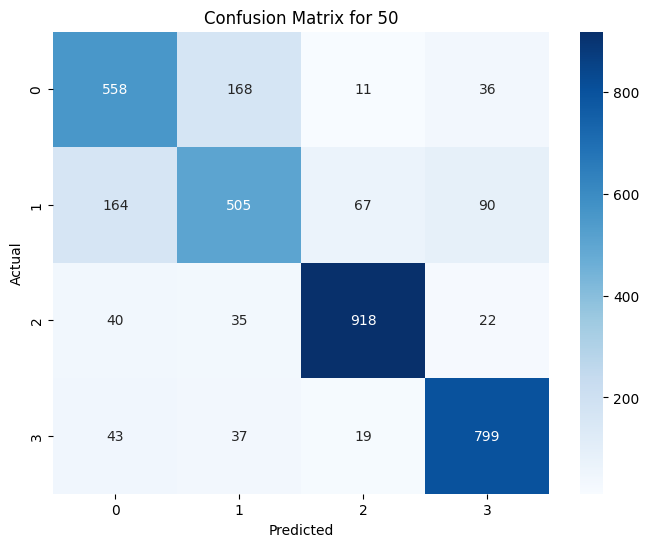

88/88 ━━━━━━━━━━━━━━━━━━━━ 11s 99ms/step

Metrics for test split 40:
Test Accuracy: 0.7936
AUC: 0.9473
Average Precision (AUPR): 0.8690
Balanced Accuracy: 0.7849
Precision: 0.7929
Recall: 0.7936
F1 Score: 0.7876
Support: {0: 608.0, 1: 670.0, 2: 809.0, 3: 723.0}


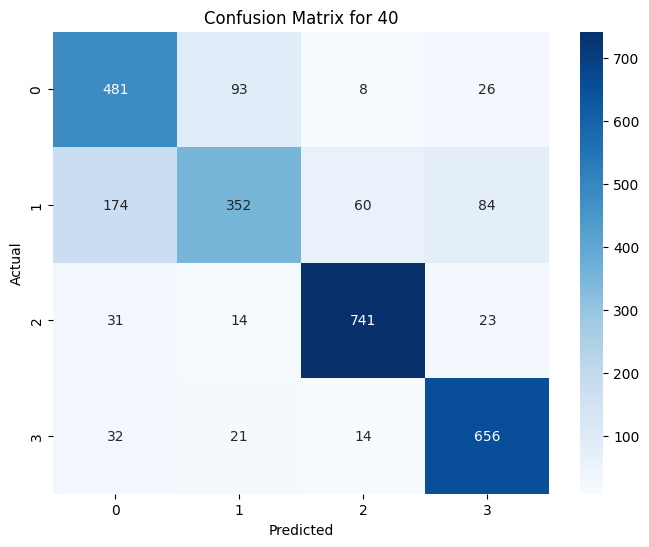

66/66 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step

Metrics for test split 30:
Test Accuracy: 0.8092
AUC: 0.9486
Average Precision (AUPR): 0.8731
Balanced Accuracy: 0.7963
Precision: 0.8070
Recall: 0.8092
F1 Score: 0.8068
Support: {0: 435.0, 1: 514.0, 2: 613.0, 3: 545.0}


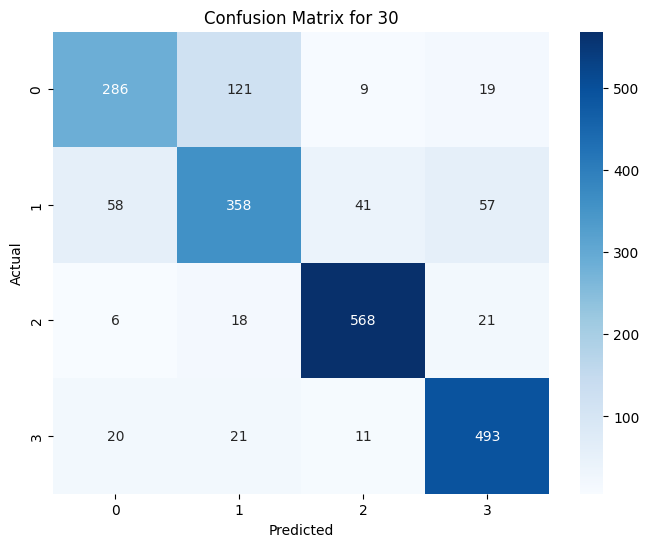

44/44 ━━━━━━━━━━━━━━━━━━━━ 9s 163ms/step

Metrics for test split 20:
Test Accuracy: 0.8149
AUC: 0.9542
Average Precision (AUPR): 0.8845
Balanced Accuracy: 0.8042
Precision: 0.8164
Recall: 0.8149
F1 Score: 0.8124
Support: {0: 278.0, 1: 340.0, 2: 411.0, 3: 376.0}


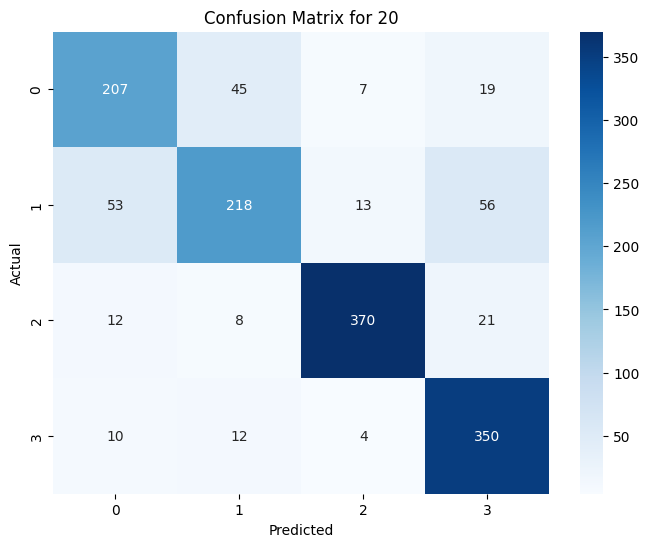

22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 300ms/step

Metrics for test split 10:
Test Accuracy: 0.8307
AUC: 0.9551
Average Precision (AUPR): 0.8888
Balanced Accuracy: 0.8237
Precision: 0.8308
Recall: 0.8307
F1 Score: 0.8282
Support: {0: 144.0, 1: 178.0, 2: 193.0, 3: 188.0}


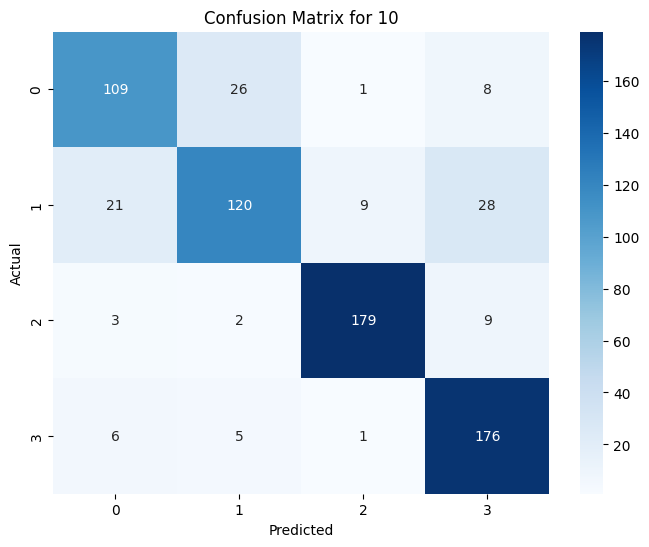

In [ ]:
from sklearn.metrics import (
    roc_auc_score, average_precision_score, balanced_accuracy_score,
    precision_score, recall_score, f1_score, classification_report, confusion_matrix
)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

metrics = {}

for split_name, model in models.items():

    split_key = split_name.replace("model_", "")

    x_test_split, y_test_split = splits[split_key][1], splits[split_key][3]

    y_pred_proba = model.predict(x_test_split)
    y_pred = y_pred_proba.argmax(axis=1)

    test_loss, test_accuracy = model.evaluate(x_test_split, y_test_split, verbose=0)

    auc = roc_auc_score(y_test_split, y_pred_proba, multi_class='ovr')
    avg_precision = average_precision_score(y_test_split, y_pred_proba, average='weighted')
    balanced_acc = balanced_accuracy_score(y_test_split, y_pred)
    precision = precision_score(y_test_split, y_pred, average='weighted')
    recall = recall_score(y_test_split, y_pred, average='weighted')
    f1 = f1_score(y_test_split, y_pred, average='weighted')

    class_report = classification_report(y_test_split, y_pred, output_dict=True)
    support = {label: class_report[str(label)]['support'] for label in range(num_classes)}

    conf_matrix = confusion_matrix(y_test_split, y_pred)

    metrics[split_key] = {
        'Test Accuracy': test_accuracy,
        'AUC': auc,
        'Average Precision (AUPR)': avg_precision,
        'Balanced Accuracy': balanced_acc,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'Support': support,
        'Confusion Matrix': conf_matrix
    }

    print(f"\nMetrics for test split {split_key}:")
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print(f"AUC: {auc:.4f}")
    print(f"Average Precision (AUPR): {avg_precision:.4f}")
    print(f"Balanced Accuracy: {balanced_acc:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Support: {support}")

    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(num_classes), yticklabels=range(num_classes))
    plt.title(f"Confusion Matrix for {split_key}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()
